# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code from [lecture 5](https://numeconcopenhagen.netlify.com/lectures/Workflow_and_debugging).
> 1. Remember this [guide](https://www.markdownguide.org/basic-syntax/) on markdown and (a bit of) latex.
> 1. Turn on automatic numbering by clicking on the small icon on top of the table of contents in the left sidebar.
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [1]:
import numpy as np
from scipy import optimize
import sympy as sm

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Model description

We consider the **standard OLG-model** where:

We assume that utility is given by $u(c)$ with constant relative risk aversion (CRRA utility function): 

\begin{equation}
  u(c)=\begin{cases}
    \frac{c^{1-\sigma}-1}{1-\sigma} , & \sigma ≠ 1 \\
    log c, & \sigma = 1
  \end{cases}
\end{equation}

Individuals live for two periods, t = 1,2. $L_t$ individuals are born in period t and we assume that the population grows with a constant rate, n: 

$$ L_t = L_{t-1}(1+n) $$

agents derive utility while alive: 

$$ U_t = u(c_{1t})+\frac{1}{1+\rho} u(c_{2t}) $$

Agtens' budget constraint in each period is given by: 

$$ c_{1t} + s_t = w_t $$

$$ c_{2t+1} = (1+r_{t+1}) s_t $$

This implies that agents' lifetime budget constraint is given by: 

$$ c_{1t} + \frac{c_{2t+1}}{1+r_{t+1}} = w_t $$



# Analytical solution

## Household problem

Every agtens born at time t maximize utility subject to their lifetime budget constraint.

For now, we assume $\sigma = 1$, which imply that utility is given by $u(c) = log (c)$

First we define all **symbols**:

In [2]:
c_1t = sm.symbols('c_1t')
c_2t = sm.symbols('c_2t+1')
rho = sm.symbols('rho')
u_1 = sm.symbols('u_1')
u_2 = sm.symbols('u_2')
sigma = sm.symbols('sigma')
w = sm.symbols('w_t')
r_t1 = sm.symbols('r_t+1')
lamb = sm.symbols('lambda')
s = sm.symbols('s_t')
k_2t = sm.symbols('k_t+1')
k_1t = sm.symbols('k_t')
alpha = sm.symbols('alpha')
n = sm.symbols('n')
k_star = sm.symbols('k^*')
Y = sm.symbols('Y_t')
K = sm.symbols('K_t')
L_t = sm.symbols('L_t')
r = sm.symbols('r_t')

In [3]:
#Lifetime utility
u_c1 = sm.ln(c_1t)
u_c2 = sm.ln(c_2t)
U = u_c1 + u_c2/(1+rho)
U

log(c_1t) + log(c_2t+1)/(rho + 1)

In [4]:
# Lagrangian
budget_l = c_1t + c_2t/(1+r_t1) - w
L = U - lamb * budget_l
L



-lambda*(c_1t + c_2t+1/(r_t+1 + 1) - w_t) + log(c_1t) + log(c_2t+1)/(rho + 1)

In [5]:
def Lan(x):
    L_1 = sm.diff(L, x)
    L_2 = sm.Eq(L_1,0)
    L_3 = sm.solve(L_2, lamb) [0]
    return L_3

L_c1 = Lan(c_1t)
L_c2 = Lan(c_2t)

Eu = sm.Eq(L_c1, L_c2)
Eu_1 = sm.solve(Eu, c_2t) [0]
Euler = sm.Eq(c_2t, Eu_1)
Euler

Eq(c_2t+1, c_1t*(r_t+1 + 1)/(rho + 1))

In [6]:
budget_1 = w-s 
budget_2 = (1+r_t1)*s

savings_1 = Euler.subs(c_1t,budget_1)

savings_2 = savings_1.subs(c_2t, budget_2)

savings = sm.solve(savings_2,s)[0]

opt_savings = sm.Eq(s,savings)
opt_savings

Eq(s_t, w_t/(rho + 2))

In [7]:
Y = K**alpha*L_t**(1-alpha)
k_t = sm.diff(Y,K)
k_t = sm.simplify(k_t)
k_t

K_t**(alpha - 1)*L_t**(1 - alpha)*alpha

divide by L

In [8]:
rr = sm.Eq(r,alpha*k_1t**(alpha-1))
rr

Eq(r_t, alpha*k_t**(alpha - 1))

In [9]:
# In equilibrium s = K*L = k
# We know that w is the marginal product of labor and given that the production function is a cobb-douglas we can insert w:

capital = sm.Eq(k_2t*(1+n), (((1-alpha)*k_1t**alpha)/(rho+2)))
capital

# In equilibrium k_t+1 = k_t = k^* so: 

capital_eq=sm.Eq(k_star*(1+n), (((1-alpha)*k_star**alpha)/(rho+2)))
Equilibrium = sm.solve(capital_eq,k_star)[0]
Equilibrium

((1 - alpha)/(n*rho + 2*n + rho + 2))**(-1/(alpha - 1))

## Numerical solution

Define the model **parameters**:

In [5]:
sigma = 1
rho = 0.05
n = 0.02
alpha = 0.33

## Define functions

In [6]:
def wage(k,alpha):
    return (1-alpha)*k**alpha

def rr(k,alpha):
     return alpha*k**(alpha-1)
     
def capital_2t(s,n):
    return s/(1+n) 

def savings(w,rho):
    return w/(2+rho)

def transition(k,alpha,rho,n):
    w = wage(k,alpha)
    s = savings(w,rho)
    return capital_2t(s,n)

In [7]:
def transition_curve(alpha,rho,n):

    # a. grids
    capital_1 = np.linspace(1e-8,0.3,500)
    capital_2 = np.empty(500)

    #b. solve for each k in grid
    for i,k in enumerate(capital_1):
        
        # i. capital in t+1
        result = transition(k,alpha,rho,n)
        capital_2[i] = result

    return capital_1,capital_2


In [8]:
capital_1,capital_2 = transition_curve(alpha,rho,n)

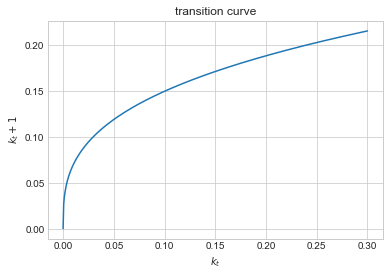

In [9]:
# c. plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(capital_1,capital_2)
ax.set_xlabel('$k_t$')
ax.set_ylabel('$k_t+1$')
ax.set_title('transition curve');

## Introduce CRRA utility

We now return to the general case, where $u(c)$ is given by the CRRA utility function: 

\begin{equation}
  u(c)=\begin{cases}
    \frac{c^{1-\sigma}-1}{1-\sigma} , & \sigma ≠ 1 \\
    log c, & \sigma = 1
  \end{cases}
\end{equation}

This imply that the Euler equation is given by: 

$$ c_{2t+1} = (\frac{1+r_{t+1}}{1+\rho})^\frac{1}{\sigma} c_{1t} $$

Inserting the budget constraint and solve for s, optimal savings is given by: 

$$ s_t = \frac{1}{(1+r_{t+1})^\frac{\sigma-1}{\sigma}(1+\rho)^\frac{1}{\sigma} +1} w_t $$

where the wage and the interest rate is given by: 

$$ w_t = (1-\alpha)k_t^\alpha $$

$$ r_{t+1} = \alpha k^{\alpha-1} $$

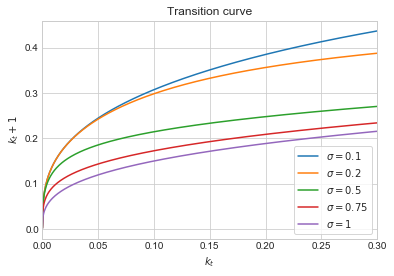

In [10]:

def savings2(w,r,rho,sigma):
    return (1/((1+r)**((sigma-1)/sigma)*(1+rho)**(1/sigma)+1))*w

def transition2(k,alpha,sigma,rho,n):
    w = wage(k,alpha)
    r = rr(k,alpha) 
    s = savings2(w,r,rho,sigma)
    return capital_2t(s,n)

def transition_curve(alpha,rho,n):

    # a. grids
    capital_1 = np.linspace(1e-8,0.3,500)
    capital_2 = np.empty(500)

    #b. solve for each k in grid
    for i,k in enumerate(capital_1):
    
        # i. capital in t+1
         result = transition2(k,alpha,sigma,rho,n)
         capital_2[i] = result

    return capital_1,capital_2

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for sigma in [0.1,0.2,0.5,0.75,1]:
    capital_1,capital_2 = transition_curve(alpha,rho,n)
    ax.plot(capital_1,capital_2,label=f'$\sigma = {sigma}$')

ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$k_t$')
ax.set_ylabel('$k_t+1$')
ax.set_title('Transition curve')
ax.set_xlim([0,0.3]);


## PAYG System

The government raises $d_t$ from the current young in period t and pays them out as benefits to current old:

$$(1+n)d_t = b_t$$

where $d_t$ is a fixed fraction of the wage income, such that: $d_t=\tau w_{t}$.


Thus we get a new budget constraint for the young in period t:

$$ c_{1t} + s_t + d_t = w_t$$

and a new budget constraint for them when old in period t+1 given by:
$$ c_{2t+1} = (1+r_{t+1})s_t + (1+n)d_{t+1} $$

We return to the case where utility $u(c)=log(c)$.  


In [11]:
def d1(w,tau):
    return tau*w

def savings(w,rho,d,r,n):
    return (1/(2+rho))*((w-d)-((1+rho/(1+r))*(1+n)*d))

def transition(k,alpha,rho,n,tau):
    w = wage(k,alpha)
    d = d1(w,tau)
    r = rr(k,alpha)
    s = savings(w,rho,d,r,n)
    return capital_2t(s,n)

In [12]:
tau = 0.3
def transition_curve(alpha,rho,n,tau):

    # a. grids
    capital_1 = np.linspace(1e-8,0.3,500)
    capital_2 = np.empty(500)

    #b. solve for each k in grid
    for i,k in enumerate(capital_1):
        
        # i. capital in t+1
        result = transition(k,alpha,rho,n,tau)
        capital_2[i] = result

    return capital_1,capital_2

capital_3,capital_4 = transition_curve(alpha,rho,n,tau)

In [20]:
def fig(alpha, rho, n, tau):
    
    capital_3,capital_4 = transition_curve(alpha,rho,n,tau)
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(capital_3,capital_4, label=f'PAYG')
    ax.plot(capital_1,capital_2, label=f'Simple')
    ax.legend(loc='lower right',facecolor='white',frameon=True)
    ax.set_xlabel('$k_t$')
    ax.set_ylabel('$k_t+1$')
    ax.set_title('transition curve');

    return 
    
import ipywidgets as widgets
widgets.interact(transition_curve(alpha,rho,n,tau),
                 alpha = widgets.fixed(alpha), 
                 rho = widgets.fixed(rho),
                 n = widgets.fixed(n),
                 tau=widgets.FloatSlider(description="$\tau$", min=0, max=1, step=0.05, value=2)
);       

interactive(children=(FloatSlider(value=1.0, description='$\tau$', max=1.0, step=0.05), Output()), _dom_classe…

In [63]:
def func(k):
    s = -k + (1/(2+rho)*(1-alpha)*k**alpha*(1+n))
    return s

def objective(k,rho,alpha,n):
    return -func(k)


def print_ss(objective,alpha,n,rho):
    solutionk = optimize.minimize_scalar(
    objective,method='bounded',
    bounds=(0,1),args=(rho,alpha,n))

    kstar = solutionk.x
    wstar = (1-alpha)*kstar**alpha
    sstar = kstar/(1+n)
    c1star = wstar-sstar
    c2star = (1+(alpha*kstar**alpha))*sstar
    Ustar = c1star + (1/(1+rho))*c2star

    print("k* = {:6.4}".format(kstar))
    print("w* = {:6.4}".format(wstar))
    print("s* = {:6.4}".format(sstar))
    print("c1* = {:6.4}".format(c1star))
    print("c2* = {:6.4}".format(c2star))
    print("U* = {:6.4}".format(Ustar))

print_ss(objective,alpha,n,rho)

k* = 0.03709
w* = 0.2259
s* = 0.03637
c1* = 0.1895
c2* = 0.04041
U* =  0.228


# Conclusion

ADD CONCISE CONCLUSION.